## UDG Lensing

In this notebook we do a simple projection for the expected UDG lensing signal using the DC2 catalogs. We explore the approximate signal-to-noise ratio (SNR) given some number density estimated from DES data, then investigate the degradation from photo-z and shape noise.

Simply, we expect the shape noise to increase the noise and the photo-z to dilute the signal. 

In [1]:
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
import numpy as np
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
import healpy as hp
import kmeans_radec
from scipy import linalg

Populating the interactive namespace from numpy and matplotlib


In [2]:
def radec2thetaphi(ra, dec, nside):
    """
    Convert RA DEC in degrees to THETA and PHI in Healpix 
    convention. 
    """

    theta = (90.0 - dec)*np.pi/180.0
    phi = ra*np.pi/180.0
    return theta, phi

def make_mask(ra, dec, nmin=1, nside=4096):
    """
    Take RA, DEC, build a binary mask just by assigning 
    1 to pixels with count>=nmin and 0 otherwise. Mask 
    is in Healpix format with assigned nside. 
    """
    mask = np.zeros(hp.nside2npix(nside))
    theta, phi = radec2thetaphi(ra, dec, nside)
    pix = hp.ang2pix(nside, theta, phi, nest=False)
    for i in range(len(pix)):
        mask[pix[i]] += 1
    mask[mask>=nmin] = 1
    mask[mask!=1] = 0

    return mask

def make_jk(ra_ran, dec_ran, ra, dec, N=100, dilute_factor=1, rand_out=0, large_mem=True, maxiter=500, tol=1e-05, seed=100):
    """
    Given coordinate of random points, generate JK indecies 
    for another catalog of positions. Include the possibility 
    of diluting the random catalog. Return an array of JK 
    indicies the same length of ra and dec.  
    """

    RADEC_ran = np.zeros((len(ra_ran),2))
    RADEC_ran[:,0] = ra_ran
    RADEC_ran[:,1] = dec_ran

    RADEC = np.zeros((len(ra),2))
    RADEC[:,0] = ra
    RADEC[:,1] = dec

    np.random.seed(seed)
    ids = np.arange(len(ra_ran))
    np.random.shuffle(ids)
    RADEC_ran_dilute = np.zeros((int(len(ra_ran)/dilute_factor),2))
    RADEC_ran_dilute[:,0] = ra_ran[ids[:int(len(ra_ran)/dilute_factor)]]
    RADEC_ran_dilute[:,1] = dec_ran[ids[:int(len(ra_ran)/dilute_factor)]]

    km = kmeans_radec.kmeans_sample(RADEC_ran_dilute, N, maxiter=500, tol=1e-05)

    if large_mem == True:
        Ntotal = len(RADEC)
        Ntotal_ran = len(RADEC_ran)

        JK = np.array([])
        JK_ran = np.array([])

        for i in range(99):
            #print i
            JK = np.concatenate((JK, km.find_nearest(RADEC[i*int(Ntotal/100):(i+1)*int(Ntotal/100)])), axis=0)
            print(np.unique(JK))

            if rand_out==1:
                JK_ran = np.concatenate((JK_ran, km.find_nearest(RADEC_ran[i*int(Ntotal_ran/100):(i+1)*int(Ntotal_ran/100)])), axis=0)

        JK = np.concatenate((JK, km.find_nearest(RADEC[99*int(Ntotal/100):])), axis=0)
        if rand_out==1:
            JK_ran = np.concatenate((JK_ran, km.find_nearest(RADEC_ran[99*int(Ntotal_ran/100):])), axis=0)
#         print('len of random', len(ra_ran))
#         print('len of JK', len(JK_ran))

    else:
        JK = km.find_nearest(RADEC)
        if rand_out==1:
            JK_ran = km.find_nearest(RADEC_ran)
    
    if rand_out==1:    
        return JK_ran, JK
    else:
        return JK, JK


In [3]:
def null_matrix(mat):
    cov_small = mat.copy()
    cov_small = cov_small[~np.all(cov_small == 0, axis=1)]
    cov_small = cov_small.T[~np.all(cov_small.T == 0, axis=1)]
    return cov_small.T

def calculate_snr(data, cov, R, Rmin, Rmax):
    mask = (R>=Rmin)*(R<Rmax)
    data_masked = data[mask]
    cov_masked = null_matrix(mask*(mask*cov).T)
    return np.dot(np.dot(data_masked, linalg.inv(cov_masked)), data_masked)**0.5

In [4]:
# A = np.ones((5,5))
# print(np.array([False, True, True, True, False])*(np.array([False, True, True, True, False])*A).T)

### First we take a look at the DC2 catalogs

First look at the distribution of stellar mass and redshift. There seems to be some structure at z=0.045, not sure what that is!

Text(0, 0.5, '$\\log_{10}(M*/Msun)$')

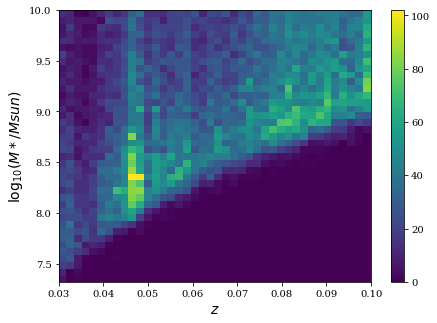

In [5]:
lens = pf.open('cosmoDC2_UDG_lens.fits')[1].data
source = pf.open('cosmoDC2_UDG_source.fits')[1].data

Z = lens['Z']
SM = np.log10(lens['SM'])

mplot.figure(figsize=(7,5))
mplot.hist2d(Z, SM, bins=(40,40))
mplot.colorbar()
mplot.xlabel('$z$', fontsize=14)
mplot.ylabel('$\log_{10}(M*/Msun)$', fontsize=14)

Text(0.5, 0, '$\\log_{10}(M*/Msun)$')

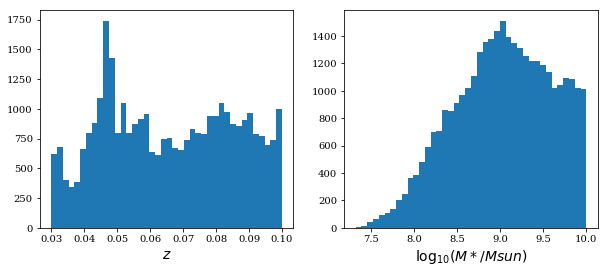

In [6]:
mplot.figure(figsize=(10,4))
mplot.subplot(121)
mplot.hist(Z, bins=40)
mplot.xlabel('$z$', fontsize=14)
mplot.subplot(122)
mplot.hist(SM, bins=40)
mplot.xlabel('$\log_{10}(M*/Msun)$', fontsize=14)


Text(0, 0.5, 'DEC')

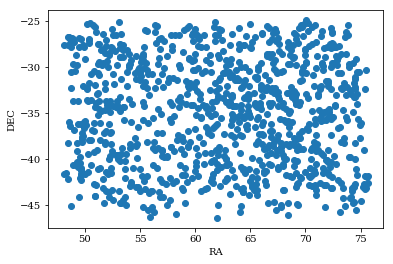

In [7]:
ids = np.arange(len(lens))
np.random.shuffle(ids)
mplot.scatter(lens['RA'][ids[:1000]], lens['DEC'][ids[:1000]])
mplot.xlabel('RA')
mplot.ylabel('DEC')

The total area of DC2_image on the sky is 436 deg$^{2}$ from previous estimation.

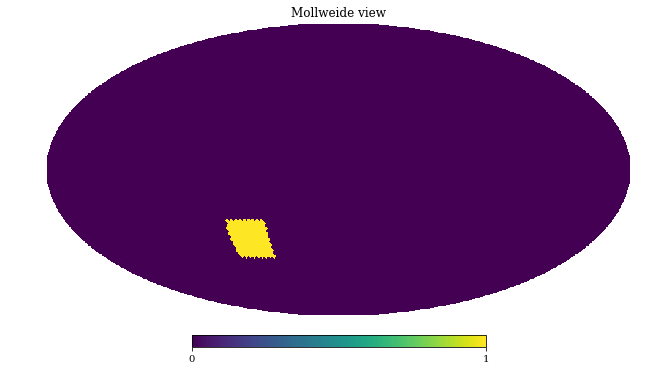

In [8]:
area = 436.43269550980676

# make a healpix mask for the lenses
nside = 512
lens_mask = make_mask(source['RA'], source['DEC'], nmin=1, nside=nside)
hp.mollview(lens_mask)

Here we calculate the equivalent shape noise we should add based on the number density, assuming DES final source number density to be 10/arcmin$^{2}$.

In [9]:
print(len(source['ra']))
n = 5922448*1.0/area/60/60 # len(source['RA'])*1.0/area/60/60
print(n)
print('shape noise per component', (0.26**2/10.0*n)**0.5)
#print(np.std(source['e1']))

1050195
3.7694802918528776
shape noise per component 0.15962984298972874


In [10]:
JK = make_jk(source['RA'], source['DEC'], lens['RA'], lens['DEC'], N=50, dilute_factor=5, seed=100)

X (916, 2)  centers (50, 2)  tol=1e-05  maxiter=500
23 iterations  cluster sizes: [15 21 13 16 11 14 28 14  8  7 25 19 23 21 12 14 20 13 17 14 29 24 31 19
 21 12 15 21 28 17 19 16 12 12 19  8 19 17 21 23 29 12 17 16 30 24 17 18
 32 13]
X (210039, 2)  centers (50, 2)  tol=1e-05  maxiter=500
117 iterations  cluster sizes: [4347 4448 4101 4109 4569 4560 4371 4635 3674 4451 4061 4392 3787 4434
 3776 3696 4016 5121 5369 4058 4328 3433 3367 4335 4587 4096 3612 4040
 4484 4181 4772 4409 3640 4626 4054 4265 4289 4203 4369 4063 3963 4022
 4015 4059 3858 4938 4291 3831 4215 3719]
[ 1. 28. 47.]
[ 1. 28. 47.]
[ 1. 20. 23. 27. 28. 47.]
[ 1. 20. 23. 27. 28. 30. 47.]
[ 1. 20. 23. 27. 28. 30. 47.]
[ 1. 20. 23. 27. 28. 30. 47.]
[ 1. 12. 20. 23. 27. 28. 30. 47. 48.]
[ 1. 12. 20. 23. 27. 28. 30. 47. 48.]
[ 1. 12. 20. 23. 27. 28. 30. 39. 47. 48. 49.]
[ 1. 12. 20. 23. 27. 28. 30. 39. 47. 48. 49.]
[ 1. 12. 20. 23. 27. 28. 30. 39. 47. 48. 49.]
[ 1. 12. 13. 20. 23. 27. 28. 30. 39. 47. 48. 49.]
[ 1. 12. 13. 20

In [11]:
print(len(JK))
c1 = pf.Column(name='JK', format='E', array=JK[0])

CC = [c1]
hdu = pf.BinTableHDU.from_columns(CC, nrows=len(JK[0]))
#hdu.writeto('cosmoDC2_UDG_lens_JK.fits', clobber=True)

2


Text(0, 0.5, 'DEC')

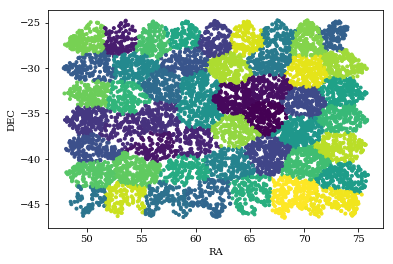

In [10]:
ids = np.arange(len(lens))
np.random.shuffle(ids)
mplot.scatter(lens['RA'][ids[:10000]], lens['DEC'][ids[:10000]],c=JK[0][ids[:10000]], marker='.')
mplot.xlabel('RA')
mplot.ylabel('DEC')

Adjust the mass cut so that the UDG number density is roughly consistent with what Dimitrios found (5 per deg$^{2}$) --> decide to use mass cut of $8.3 < \log_{10}(M*/Msun)<8.5$

In [11]:
print('Total # of galaxies:', len(lens), '('+str(len(lens)*1.0/area/60/60)+' per arcmin^2)')
print('We expect LSB galaxies', 5*area)
mask = (Z>0.03)*(Z<0.1)*(SM>8.3)*(SM<8.5)
print('# of galaxies after cut:', len(lens[mask]))

Total # of galaxies: 33159 (0.021104819661996115 per arcmin^2)
We expect LSB galaxies 2182.163477549034
# of galaxies after cut: 2530


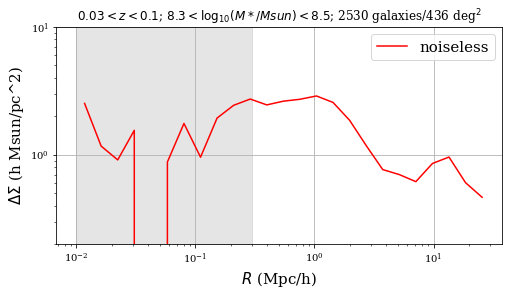

In [61]:
h = 0.7
infile = np.load('DeltaSigma_cosmoDC2_UDG_0.03_0.1_8.3_8.5.npz')

mplot.figure(figsize=(8,4))
ax = mplot.subplot(111)
mplot.loglog(infile['R']*h,np.sum(infile['gt'], axis=0)/np.sum(infile['npairs'], axis=0)/h/10**12, color='r', label='noiseless')
ax.fill_between([0.01, 0.3], [0.2, 0.2], [10,10], color='grey', alpha=0.2)

mplot.xlabel('$R$ (Mpc/h)', fontsize=15)
mplot.legend(fontsize=15)
mplot.ylabel('$\Delta \Sigma$ (h Msun/pc^2)', fontsize=15)
mplot.ylim(0.2,10)
mplot.title('$0.03<z<0.1$; $8.3<\log_{10}(M*/Msun)<8.5$; 2530 galaxies/436 deg$^2$')
mplot.grid()

### Fiducial measurement

SNR: 5.182712286316525


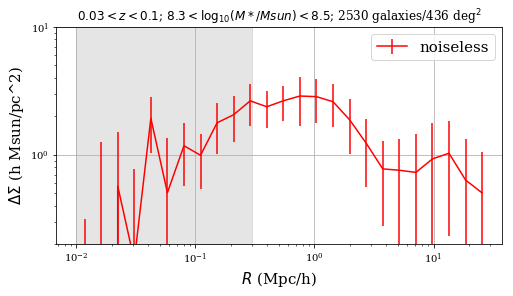

In [13]:
h = 0.7
infile = np.load('delta_sigma_cosmoDC2_UDG.npz')

mplot.figure(figsize=(8,4))
ax = mplot.subplot(111)
mplot.errorbar(infile['R']*h,infile['DS_w_mean']/h/10**12, yerr=np.diag(infile['cov_w'])**0.5/h/10**12, color='r', label='noiseless')
ax.fill_between([0.01, 0.3], [0.2, 0.2], [10,10], color='grey', alpha=0.2)
mplot.xscale('log')
mplot.yscale('log')


mplot.xlabel('$R$ (Mpc/h)', fontsize=15)
mplot.legend(fontsize=15)
mplot.ylabel('$\Delta \Sigma$ (h Msun/pc^2)', fontsize=15)
mplot.ylim(0.2,10)
mplot.title('$0.03<z<0.1$; $8.3<\log_{10}(M*/Msun)<8.5$; 2530 galaxies/436 deg$^2$')
mplot.grid()

print('SNR:', calculate_snr(infile['DS_w_mean'], infile['cov_w'], infile['R']*h, 0.3, 10))

### First look at scaling with area

In [14]:
area_fac = 5000./436
area_fac2 = 14000./436

SNR: 17.55087841274343


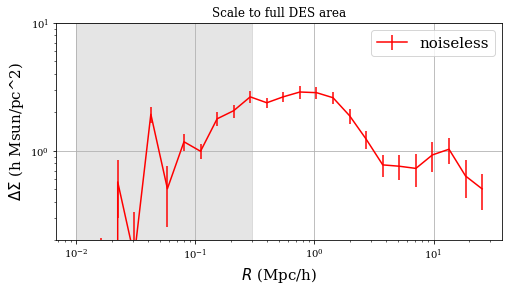

In [15]:
mplot.figure(figsize=(8,4))
ax = mplot.subplot(111)
mplot.errorbar(infile['R']*h,infile['DS_w_mean']/h/10**12, yerr=np.diag(infile['cov_w']/area_fac)**0.5/h/10**12, color='r', label='noiseless')
ax.fill_between([0.01, 0.3], [0.2, 0.2], [10,10], color='grey', alpha=0.2)
mplot.xscale('log')
mplot.yscale('log')


mplot.xlabel('$R$ (Mpc/h)', fontsize=15)
mplot.legend(fontsize=15)
mplot.ylabel('$\Delta \Sigma$ (h Msun/pc^2)', fontsize=15)
mplot.ylim(0.2,10)
mplot.title('Scale to full DES area')
mplot.grid()

print('SNR:', calculate_snr(infile['DS_w_mean'], infile['cov_w']/area_fac, infile['R']*h, 0.3, 10))

### Next look at shape noise

SNR: 1.1681752870783795
SNR: 3.955940691983861


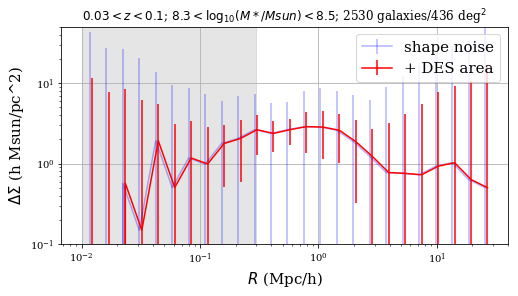

In [16]:
infile = np.load('delta_sigma_cosmoDC2_UDG.npz')
infile2 = np.load('delta_sigma_cosmoDC2_UDG_shapenoise.npz')

mplot.figure(figsize=(8,4))
ax = mplot.subplot(111)
mplot.errorbar(infile['R']*h,infile['DS_w_mean']/h/10**12, yerr=np.diag(infile2['cov_w'])**0.5/h/10**12, color='blue', label='shape noise', alpha=0.3)
mplot.errorbar(infile['R']*h*1.05,infile['DS_w_mean']/h/10**12, yerr=np.diag(infile2['cov_w']/area_fac)**0.5/h/10**12, color='r', label='+ DES area')

ax.fill_between([0.01, 0.3], [0.1, 0.1], [50,50], color='grey', alpha=0.2)
mplot.xscale('log')
mplot.yscale('log')


mplot.xlabel('$R$ (Mpc/h)', fontsize=15)
mplot.legend(fontsize=15)
mplot.ylabel('$\Delta \Sigma$ (h Msun/pc^2)', fontsize=15)
mplot.ylim(0.1,50)
mplot.title('$0.03<z<0.1$; $8.3<\log_{10}(M*/Msun)<8.5$; 2530 galaxies/436 deg$^2$')
mplot.grid()

print('SNR:', calculate_snr(infile['DS_w_mean'], infile2['cov_w'], infile['R']*h, 0.3, 10))
print('SNR:', calculate_snr(infile['DS_w_mean'], infile2['cov_w']/area_fac, infile['R']*h, 0.3, 10))

### Next look at photo-z

SNR: 4.9793693701908674


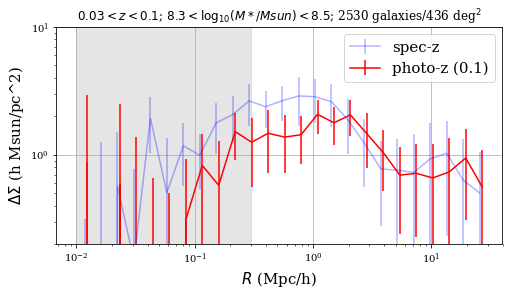

In [24]:
infile = np.load('delta_sigma_cosmoDC2_UDG_photoz2.npz')
infile2 = np.load('delta_sigma_cosmoDC2_UDG.npz')

mplot.figure(figsize=(8,4))
ax = mplot.subplot(111)
mplot.errorbar(infile['R']*h,infile2['DS_w_mean']/h/10**12, yerr=np.diag(infile2['cov_w'])**0.5/h/10**12, color='b', alpha=0.3, label='spec-z')
mplot.errorbar(infile['R']*h*1.05,infile['DS_w_mean']/h/10**12, yerr=np.diag(infile['cov_w'])**0.5/h/10**12, color='r', label='photo-z (0.1)')

ax.fill_between([0.01, 0.3], [0.1, 0.1], [50,50], color='grey', alpha=0.2)
mplot.xscale('log')
mplot.yscale('log')


mplot.xlabel('$R$ (Mpc/h)', fontsize=15)
mplot.legend(fontsize=15)
mplot.ylabel('$\Delta \Sigma$ (h Msun/pc^2)', fontsize=15)
mplot.ylim(0.2,10)
mplot.title('$0.03<z<0.1$; $8.3<\log_{10}(M*/Msun)<8.5$; 2530 galaxies/436 deg$^2$')
mplot.grid()

print('SNR:', calculate_snr(infile['DS_w_mean'], infile['cov_w'], infile['R']*h, 0.3, 10))

### Next look at shape noise + photo-z

SNR: 1.0048736559107143
SNR: 3.4029315888558536


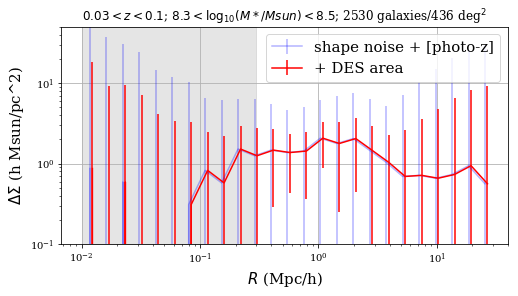

In [25]:
infile = np.load('delta_sigma_cosmoDC2_UDG_photoz2.npz')
infile2 = np.load('delta_sigma_cosmoDC2_UDG_shapenoise_photoz2.npz')

mplot.figure(figsize=(8,4))
ax = mplot.subplot(111)
mplot.errorbar(infile['R']*h,infile['DS_w_mean']/h/10**12, yerr=np.diag(infile2['cov_w'])**0.5/h/10**12, color='blue', label='shape noise + [photo-z]', alpha=0.3)
mplot.errorbar(infile['R']*h*1.05,infile['DS_w_mean']/h/10**12, yerr=np.diag(infile2['cov_w']/area_fac)**0.5/h/10**12, color='r', label='+ DES area')

ax.fill_between([0.01, 0.3], [0.1, 0.1], [50,50], color='grey', alpha=0.2)
mplot.xscale('log')
mplot.yscale('log')


mplot.xlabel('$R$ (Mpc/h)', fontsize=15)
mplot.legend(fontsize=15)
mplot.ylabel('$\Delta \Sigma$ (h Msun/pc^2)', fontsize=15)
mplot.ylim(0.1,50)
mplot.title('$0.03<z<0.1$; $8.3<\log_{10}(M*/Msun)<8.5$; 2530 galaxies/436 deg$^2$')
mplot.grid()

print('SNR:', calculate_snr(infile['DS_w_mean'], infile2['cov_w'], infile['R']*h, 0.3, 10))
print('SNR:', calculate_snr(infile['DS_w_mean'], infile2['cov_w']/area_fac, infile['R']*h, 0.3, 10))

Comments:
 
* the setup as is gives barely a detection if we add shape noise and photo-z, but one could imagine increasing S/N by changing the sample? we don't really have a good definition of UDGs atm

* photo-z assumed to be at ~0.1, it's not implimented completely correct, and not considering outliers... but I think this shows that photo-z doesn't necessarily damp the signal, it could change the shape though 

* we can see from here how the effect of shape noise is much larger than photo-z 

* haven't applied random-subtraction 

* can make predictions for LSST too? and decide whether we still want to try this with DES

* compare with Buzzard? does Buzzard have better mass resolution? the small-scale cut is somewhat artificial, though we probably don't want to push too much further